# Real or AI

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import timm
# import albumentations as albu
# from albumentations.pytorch import ToTensorV2
from torchvision import transforms

from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import copy

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, is_train=True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing file names and labels.
            data_dir (str): Directory where the image files are stored.
            transforms (callable, optional): Torchvision transforms to apply to the images.
            is_train (bool, optional): Flag to indicate if the dataset is for training.
        """
        self.df = df
        # self.df = df.head(100)
        self.data_dir = data_dir
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract the file name and label
        filename = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        # Load the image
        img_path = os.path.join(self.data_dir, filename)
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode

        # Apply transforms if specified
        if self.transforms:
            image = self.transforms(image)

        # For training, return the image and label
        if self.is_train:
            return image, label
        # For inference, return only the image
        else:
            return image

In [ ]:
BATCH_SIZE = 64
SEED = 42
IMG_SIZE = 224

LOAD_PRETRAINED_WEIGHTS = False  # Set to True to load weights and resume training
PRETRAINED_WEIGHTS_PATH = "best_model_davit_v1.pth"  # Path to checkpoint; accepts both state_dict and dict ckp formats
RESUME_FROM_EPOCH = 0  # Optional override if checkpoint doesn't contain epoch info

SAVE_DIR = "checkpoints_davit_v1"

In [ ]:
LR = 1e-5
NUM_EPOCHS = 5

In [ ]:
# Load the train CSV
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
train_df = pd.read_csv(train_csv_path)

# Define the base directory where images are stored
train_data_dir = "/kaggle/input/ai-vs-human-generated-dataset/"

# Replaced Albumentations with Torchvision Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


# Split: 0.7 Train, 0.2 Val, 0.1 Test
# First split: 0.7 Train, 0.3 Temp
train_df, temp_df = train_test_split(train_df, test_size=0.3, random_state=SEED, stratify=train_df['label'])
# Second split: Split Temp (0.3) into Val (0.2) and Test (0.1). 
# 0.1 is 1/3 of 0.3, so test_size=1/3
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=SEED, stratify=temp_df['label'])

# Dataset and DataLoader
train_dataset = CustomDataset(train_df, train_data_dir, transforms=train_transform, is_train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_dataset = CustomDataset(val_df, train_data_dir, transforms=val_transform, is_train=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataset = CustomDataset(test_df, train_data_dir, transforms=val_transform, is_train=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Iterate through the DataLoader
for images, labels in train_dataloader:
    print(images.shape, labels)
    break

for images, labels in val_dataloader:
    print(images.shape, labels)
    break

torch.Size([32, 3, 256, 256]) tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0])
torch.Size([32, 3, 256, 256]) tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0])


Dataset Balance:
label
1    27983
0    27982
Name: count, dtype: int64


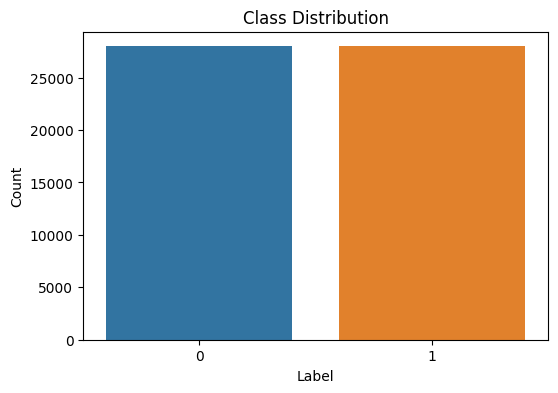

Sample Images:


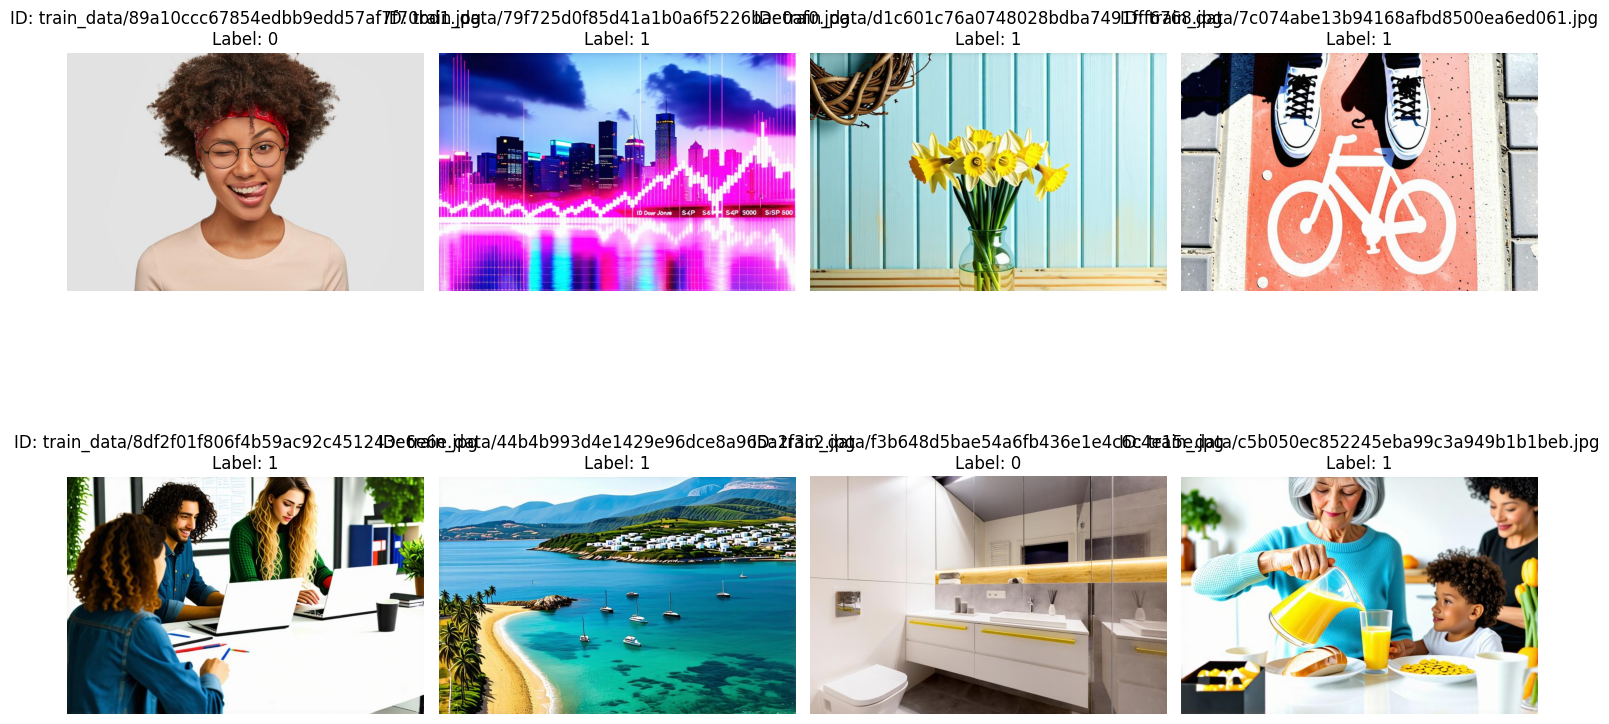

In [6]:
# 1. Check Dataset Balance
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = train_df['label'].value_counts()
print("Dataset Balance:")
print(label_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# 2. Add Data visualization Strategies - Show samples images with IDX
def show_samples(df, data_dir, num_samples=8, cols=4):
    plt.figure(figsize=(15, 10))
    samples = df.sample(num_samples)
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(data_dir, row['file_name'])
        try:
            img = Image.open(img_path)
            label = row['label']
            
            plt.subplot(num_samples // cols + (1 if num_samples % cols else 0), cols, i + 1)
            plt.imshow(img)
            plt.title(f"ID: {row['file_name']}\nLabel: {label}")
            plt.axis('off')
        except Exception as e:
            print(f"Could not load {img_path}: {e}")
    plt.tight_layout()
    plt.show()

print("Sample Images:")
show_samples(train_df, train_data_dir)

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model_name, num_classes=2, pretrained=True):
        super().__init__()
        # Load backbone without classifier (num_classes=0 returns pooled features)
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        in_features = self.backbone.num_features
        
        # Small NN head to avoid overfitting
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

# Using DaViT (Dual Attention Vision Transformer)
model_name = 'davit_small.msft_in1k'
model = CustomModel(model_name, num_classes=2)

# Define Learning Rates
BACKBONE_LR = LR  # 1e-5 (from previous cell)
HEAD_LR = 1e-3    # Higher LR for the new head

optimizer = Adam([
    {'params': model.backbone.parameters(), 'lr': BACKBONE_LR},
    {'params': model.head.parameters(), 'lr': HEAD_LR}
], weight_decay=1e-2)

scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

# 2. Implement a Strategy - Class Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset is balanced, so we don't need class weights
loss_fn = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [8]:
def visualize_predictions(model, loader, device, num_images=16):
    """
    Visualizes a grid of predictions from the model.
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 12))
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                img = images[i].cpu().permute(1, 2, 0).numpy()
                # Denormalize
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.subplot(4, 4, images_shown + 1)
                plt.imshow(img)
                plt.title(f"True: {labels[i].item()}\nPred: {preds[i].item()}", 
                          color=("green" if labels[i]==preds[i] else "red"))
                plt.axis('off')
                images_shown += 1
            
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

def validate_model(model, val_loader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            # Store labels and predictions for F1 score calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(all_labels, all_preds, average="weighted")
    val_acc = val_correct / val_total
    
    return val_loss, val_acc, val_f1

def train_model(
    model, train_loader, val_loader, optimizer, scheduler, loss_fn, device,
    num_epochs, save_path="best_model.pth", save_dir="checkpoints",
    resume=False, checkpoint_path=None, start_epoch=0
):
    """
    Trains the model and evaluates it on the validation set. Supports resuming from checkpoints.
    """
    model.to(device)
    os.makedirs(save_dir, exist_ok=True)

    # Try to load checkpoint if requested
    if resume and checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        ckpt = torch.load(checkpoint_path, map_location=device)
        if isinstance(ckpt, dict):
            try:
                if 'model_state_dict' in ckpt:
                    model.load_state_dict(ckpt['model_state_dict'])
                else:
                    model.load_state_dict(ckpt)

                # Load optimizer/scheduler if present
                if 'optimizer_state_dict' in ckpt:
                    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                if 'scheduler_state_dict' in ckpt:
                    try:
                        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
                    except Exception as e:
                        print('Could not load scheduler state:', e)

                # Determine start epoch
                start_epoch = ckpt.get('epoch', start_epoch) + 1 if ckpt.get('epoch') is not None else start_epoch
                print(f"Resuming from epoch: {start_epoch}")
            except Exception as e:
                print('Could not fully restore checkpoint; starting from start_epoch. Error:', e)
        else:
            model.load_state_dict(ckpt)
    else:
        # no resume or checkpoint not found, start at provided start_epoch
        print('Starting training from scratch' if not resume else f'Checkpoint {checkpoint_path} not found; starting from {start_epoch}')

    # Keep track of the best model
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    curr_step = 0
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs} | starting epoch {epoch}")
        print("-" * 50)
        # Training phase
        model.train()

        for batch_idx, (images, labels) in tqdm(enumerate(train_loader), desc="Training", total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute training metrics (accumulate until checkpoint event)
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            curr_step += 1

            # Validate periodically
            if curr_step % 1000 == 0:
                val_loss, val_acc, val_f1 = validate_model(model, val_loader, loss_fn, device)

                # Save the best model (full checkpoint including optimizer/scheduler states)
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': getattr(scheduler, 'state_dict', lambda: {})(),
                    }, save_path)
                    print(f"New best model saved with F1 score: {best_f1:.4f}")

                train_loss /= 1000 if curr_step >= 1000 else max(1, len(train_loader))
                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["val_f1"].append(val_f1)

                train_acc = train_correct / train_total if train_total > 0 else 0.0
                print(f"Step {curr_step}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

                print("Visualizing predictions...")
                visualize_predictions(model, val_loader, device)

                train_loss = 0.0
                train_total = 0
                train_correct = 0
                model.train()

        # End of epoch: validate and save epoch checkpoint
        print(f"End of Epoch {epoch + 1} Validation")
        val_loss, val_acc, val_f1 = validate_model(model, val_loader, loss_fn, device)

        epoch_save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': getattr(scheduler, 'state_dict', lambda: {})(),
        }, epoch_save_path)
        print(f"Saved checkpoint: {epoch_save_path}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': getattr(scheduler, 'state_dict', lambda: {})(),
            }, save_path)
            print(f"New best model saved with F1 score: {best_f1:.4f}")

        scheduler.step()

    print("Training complete.")
    print(f"Best F1 Score: {best_f1:.4f}")
    torch.save(best_model_wts, save_path)
    print(f"Best model weights saved to {save_path}")
    return best_model_wts, history

Starting training from scratch
Epoch 1/2 | starting epoch 0
--------------------------------------------------


Training:  57%|█████▋    | 999/1749 [31:39<23:43,  1.90s/it]

New best model saved with F1 score: 0.9990
Step 1000: Train Loss: 0.0346, Train Acc: 0.9856
Val Loss: 0.0031, Val Acc: 0.9990, Val F1: 0.9990
Visualizing predictions...


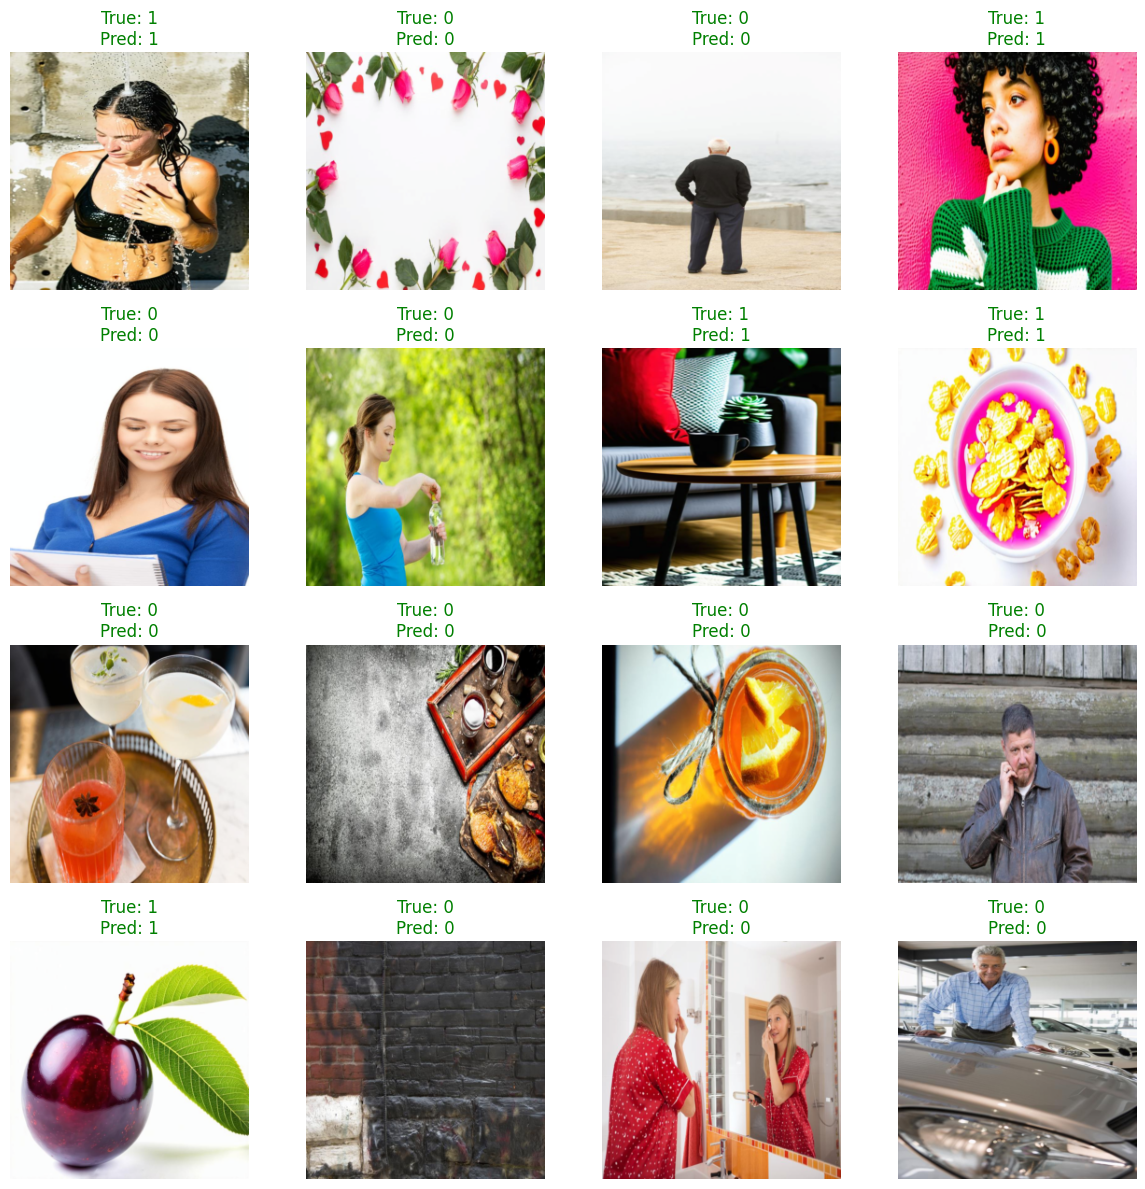

Training: 100%|██████████| 1749/1749 [59:07<00:00,  2.03s/it]

End of Epoch 1 Validation


Saved checkpoint: checkpoints_v4/model_epoch_1.pth
Epoch 2/2 | starting epoch 1
--------------------------------------------------


Training:  14%|█▍        | 250/1749 [07:55<47:25,  1.90s/it]

New best model saved with F1 score: 0.9992
Step 2000: Train Loss: 0.0103, Train Acc: 0.9970
Val Loss: 0.0023, Val Acc: 0.9992, Val F1: 0.9992
Visualizing predictions...


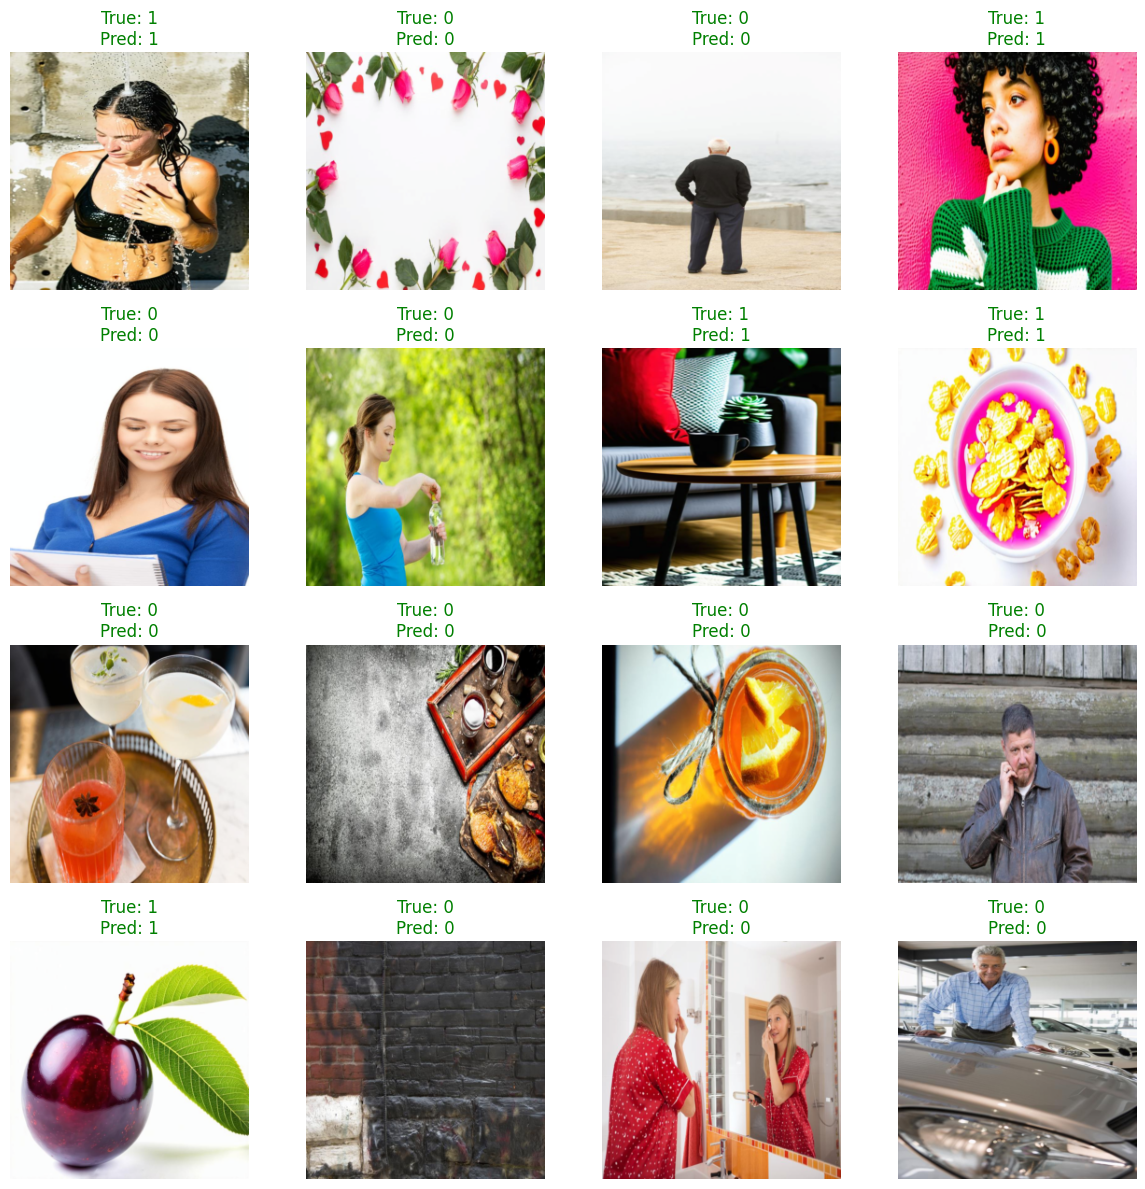

Training:  71%|███████▏  | 1250/1749 [43:18<15:47,  1.90s/it]

Step 3000: Train Loss: 0.0012, Train Acc: 0.9997
Val Loss: 0.0030, Val Acc: 0.9992, Val F1: 0.9992
Visualizing predictions...


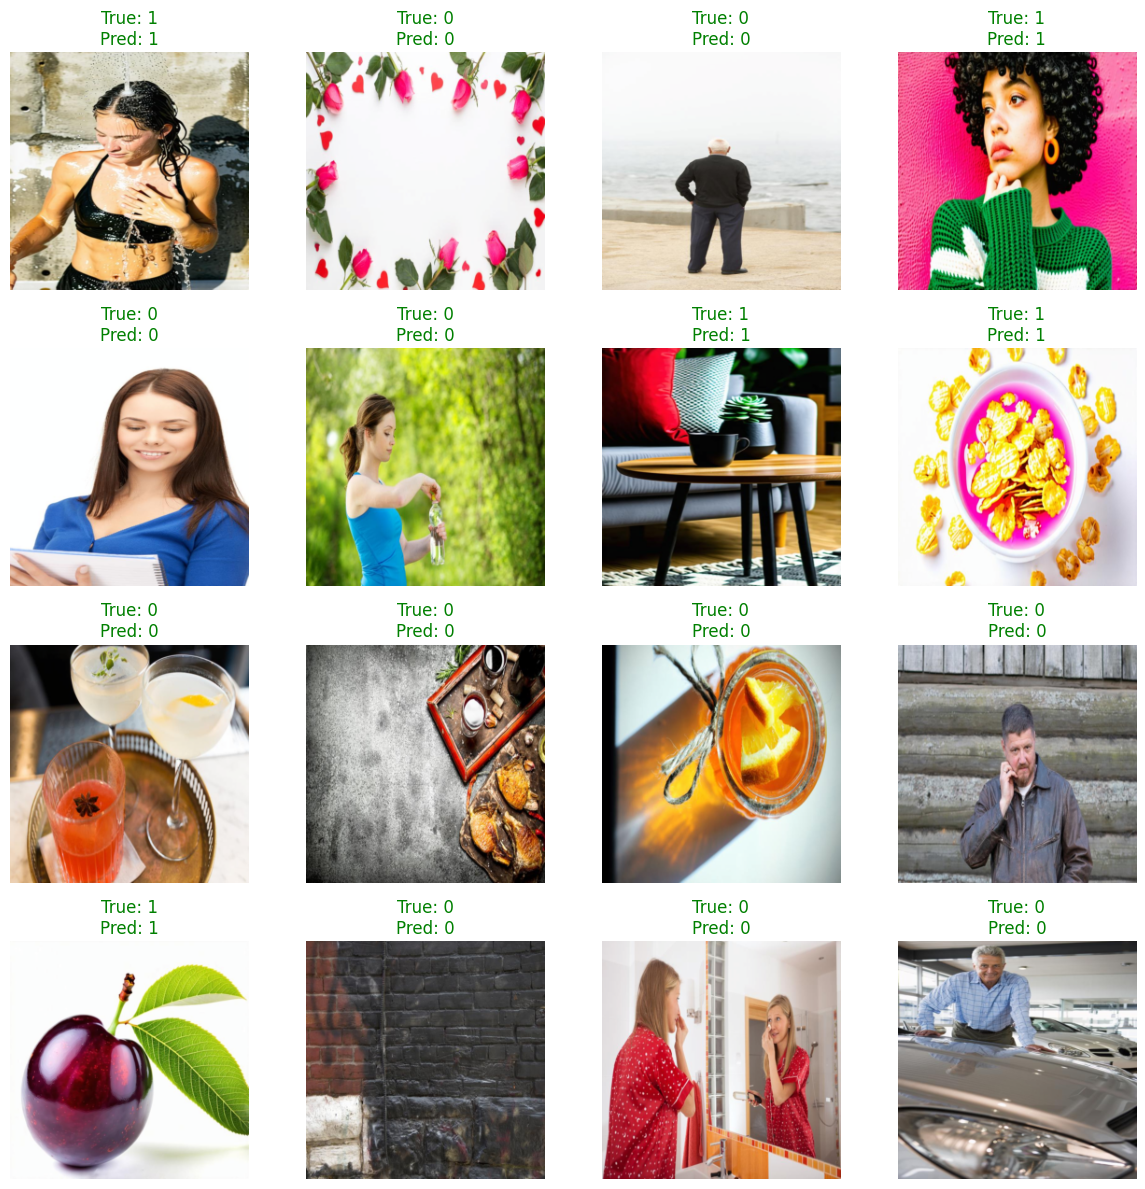

Training: 100%|██████████| 1749/1749 [1:02:48<00:00,  2.15s/it]

End of Epoch 2 Validation


Saved checkpoint: checkpoints_v4/model_epoch_2.pth
New best model saved with F1 score: 0.9992
Training complete.
Best F1 Score: 0.9992
Best model weights saved to best_model_v4.pth


<All keys matched successfully>

In [9]:
best_model_wts, history = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path=PRETRAINED_WEIGHTS_PATH,
    save_dir=SAVE_DIR,
    resume=False,
    checkpoint_path=PRETRAINED_WEIGHTS_PATH,
    start_epoch=RESUME_FROM_EPOCH
)

# Load the best model weights after training (if needed)pip install pytorch-gradcam
model.load_state_dict(best_model_wts)

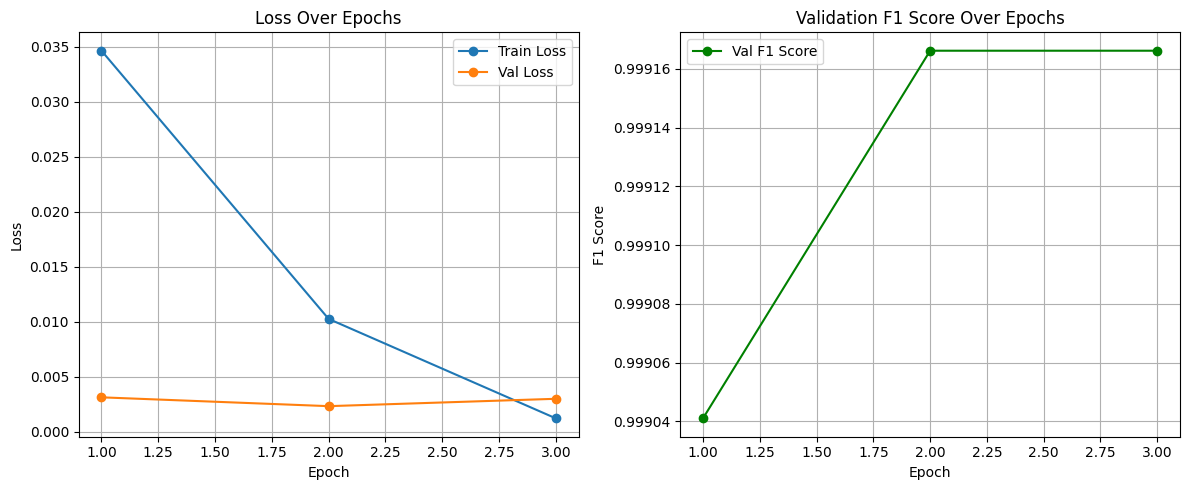

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_history(history):
    """
    Visualizes the training and validation history.

    Args:
        history (dict): Dictionary containing training and validation metrics with keys:
                        - "train_loss": List of training loss values.
                        - "val_loss": List of validation loss values.
                        - "val_f1": List of validation F1 scores.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_f1"], label="Val F1 Score", marker="o", color="green")
    plt.title("Validation F1 Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

visualize_history(history)

# --- Evaluation on Train, Val, and Test Sets ---

def evaluate_performance(model, loader, device, dataset_name="Dataset"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {dataset_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"--- {dataset_name} Performance ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Evaluating on Train Set...")
evaluate_performance(model, train_dataloader, device, "Train")
print("=="*50)

print("Evaluating on Validation Set...")
evaluate_performance(model, val_dataloader, device, "Validation")
print("=="*50)

print("\nEvaluating on Test Set...")
evaluate_performance(model, test_dataloader, device, "Test")
print("=="*50)

### Prediction

In [11]:
# Load the test CSV for predictions
test_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"
test_df = pd.read_csv(test_csv_path)

# Define the base directory where images are stored
test_data_dir = "/kaggle/input/ai-vs-human-generated-dataset"

# Update image paths in the test dataframe
test_df['img_path'] = test_df['id'].apply(lambda x: os.path.join(test_data_dir, x))

In [12]:
%%time

# Initialize a list to store results
predictions = []

# Perform inference on test images
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # if idx==100:
    #     break
    
    img_path = row['img_path']  # Path to the image
    id_ = row['id']
    try:
        # Open and preprocess image
        image = Image.open(img_path).convert("RGB")
        # Apply transforms directly to PIL image
        input_tensor = val_transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Model prediction
        with torch.no_grad():
            outputs = model(input_tensor)
            predicted_label = torch.argmax(outputs, dim=-1).item()  # Get predicted class

        predictions.append((id_, predicted_label))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

100%|██████████| 5540/5540 [05:04<00:00, 18.22it/s]

CPU times: user 4min 44s, sys: 4.84 s, total: 4min 49s
Wall time: 5min 4s


In [13]:
# Create a DataFrame for submission
submission_df = pd.DataFrame(predictions, columns=["id", "label"])

# Save to CSV for submission
submission_csv_path = "submission.csv"
submission_df.to_csv(submission_csv_path, index=False)
print(f"Submission file saved at {submission_csv_path}")

Submission file saved at submission.csv
